In [90]:
# Import all necessary libraries
import tensorflow as tf
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import random
from collections import defaultdict
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from transformers import ViTFeatureExtractor, TFViTForImageClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Global Variables

In [86]:
labels = os.listdir(r"Dataset\train")
trained_model='trained_models'
dataset_dir=os.path.join('Dataset')
cas_dir=os.path.join('Cascade')
savedmodels_dir=os.path.join('savedmodels')

# Data Exploration

In [79]:
# Check how many images we have of each class

class_distribution = defaultdict(int)
image_shapes = []
# Walk through each class folder and count the images
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_distribution[class_name] = num_images
        
        # For image shape analysis, load a sample image from each class
        sample_image_path = os.path.join(class_path, os.listdir(class_path)[0])
        sample_image = plt.imread(sample_image_path)
        image_shapes.append(sample_image.shape)

print(f"Class distribution: {class_distribution}")
print(f"Image shapes: {image_shapes}")


Class distribution: defaultdict(<class 'int'>, {'Closed': 726, 'no_yawn': 725, 'Open': 726, 'yawn': 723})
Image shapes: [(145, 145, 3), (480, 640, 3), (175, 175, 3), (480, 640, 3)]


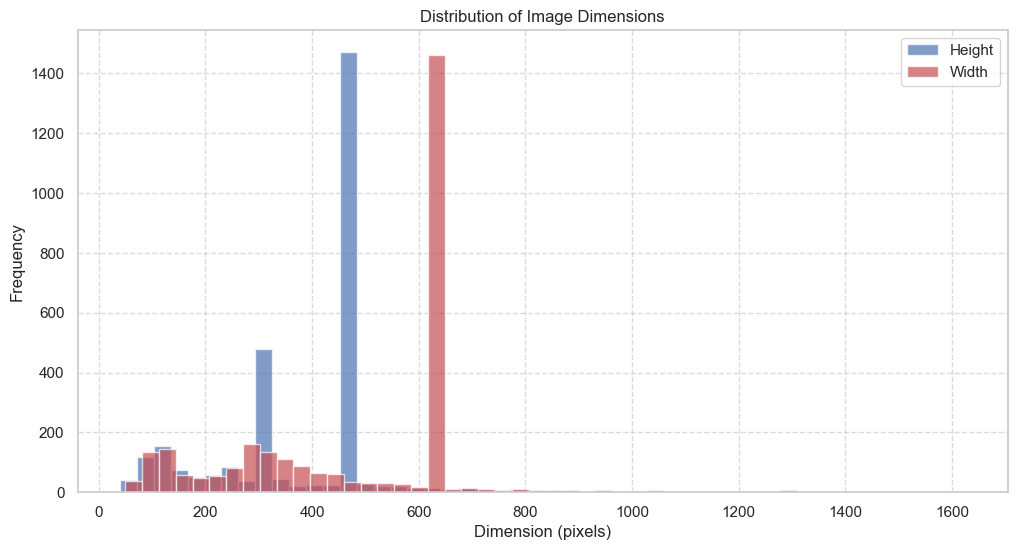

In [81]:
# Analyze the dimensions of the images to check for consistency and identify any outliers
image_shapes = []
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            image_shapes.append(img.shape[:2])  

# Convert to a NumPy array for easy analysis
image_shapes = np.array(image_shapes)
unique_shapes, counts = np.unique(image_shapes, axis=0, return_counts=True)


# Plot a histogram of image shapes (width and height)
plt.figure(figsize=(12, 6))
plt.hist(image_shapes[:, 0], bins=50, color='b', alpha=0.7, label='Height')
plt.hist(image_shapes[:, 1], bins=50, color='r', alpha=0.7, label='Width')
plt.title("Distribution of Image Dimensions")
plt.xlabel("Dimension (pixels)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## Interpretation
### Interpretation of the Histogram of Image Dimensions

1. **Distinct Peaks**: The histogram shows distinct peaks in both the height (blue) and width (red) distributions. Specifically, there is a significant concentration of images around a height of approximately 400 pixels and a width of approximately 600 pixels. This suggests that a large number of images in the dataset share these dimensions, which could be due to a common source or preprocessing step that standardized the images to these dimensions.

2. **Smaller Images**: There is also a noticeable number of images with much smaller dimensions, especially around the 100-300 pixel range for both height and width. 

3. **Potential Outliers**: The histogram indicates that there are very few images with dimensions greater than 600 pixels for height and 1000 pixels for width. These could potentially be outliers in the dataset, especially if the majority of images are much smaller.

4. **Consistency in Dimensions**: Despite the presence of a few outliers, the majority of images seem to have consistent dimensions. This consistency is beneficial as it reduces the need for extensive preprocessing and ensures that the model receives input data of similar sizes, which can help improve the efficiency of training.

5. **Implications for Model Training**: The concentration of images at specific dimensions suggests that most of the data has a uniform shape, which is advantageous for convolutional neural networks (CNNs) that require fixed input sizes. However, the presence of outliers should be addressed to avoid potential issues during model training, such as poor performance on images with non-standard dimensions.


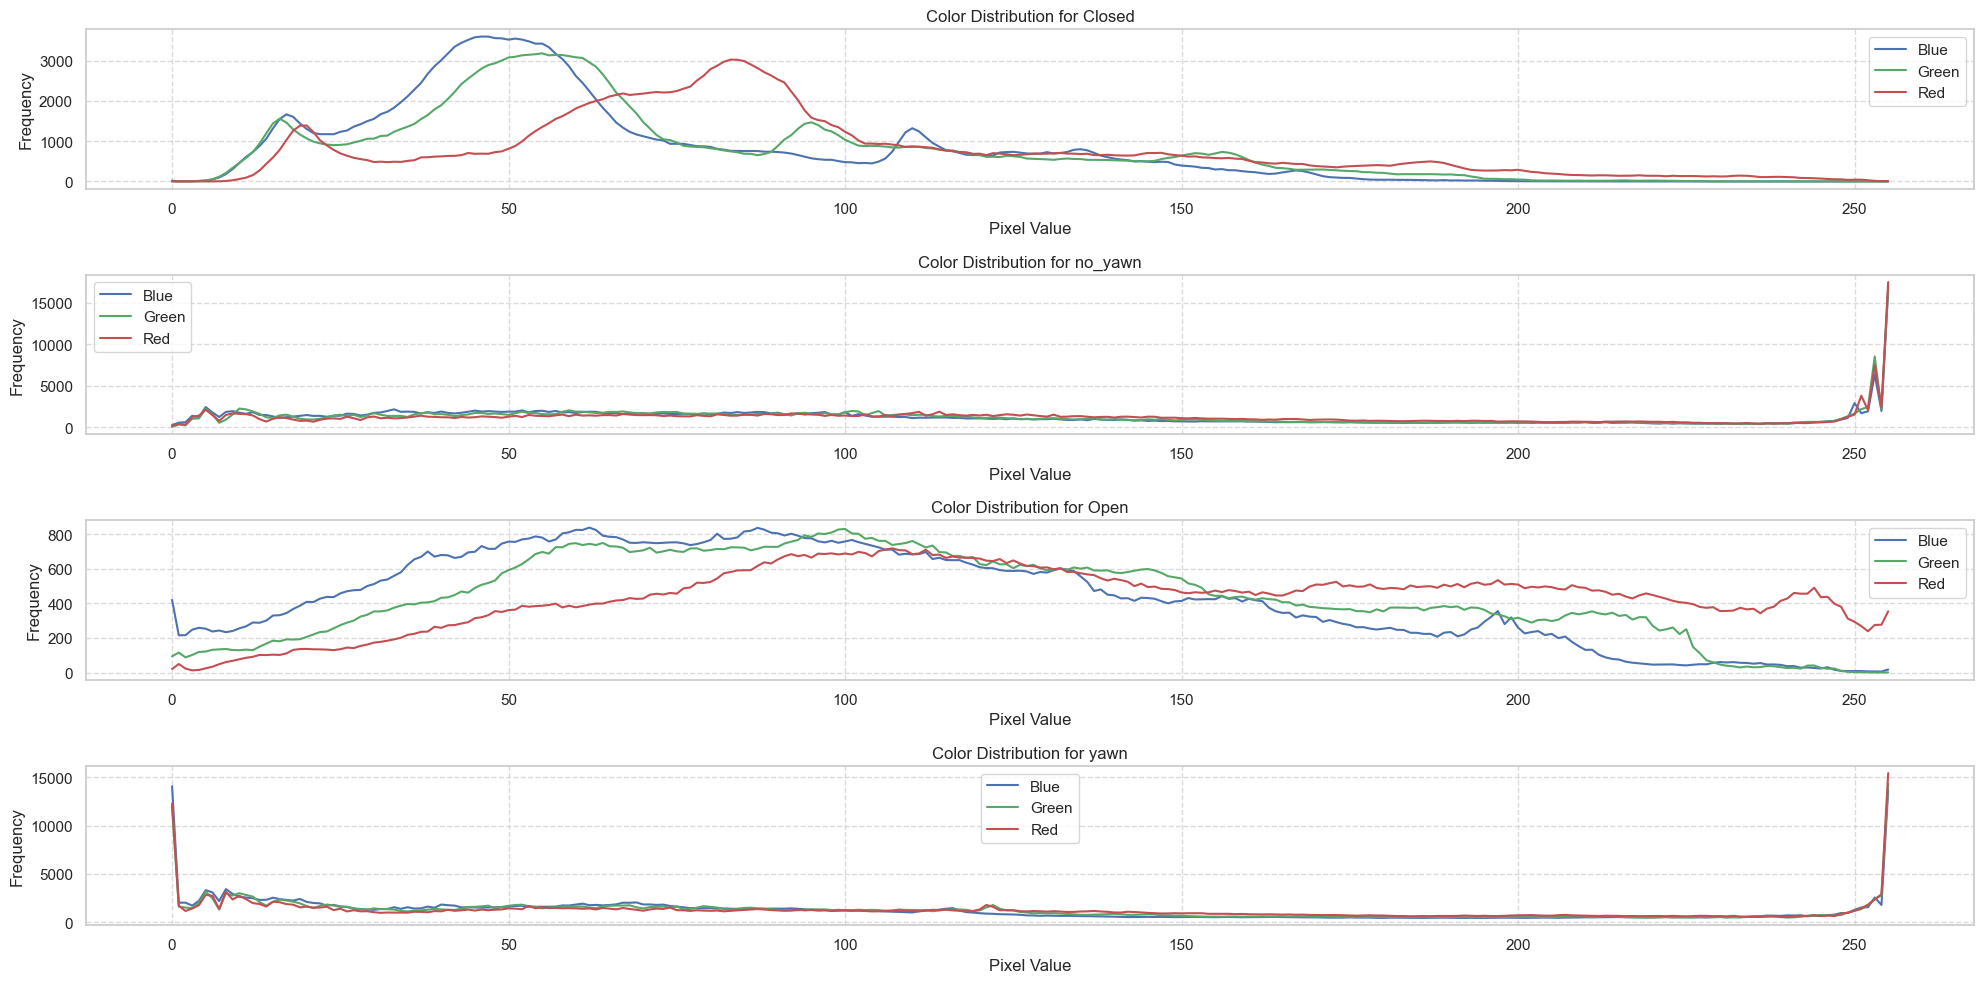

In [82]:
def plot_color_distribution(dataset_dir, class_labels, n_samples=10):
    plt.figure(figsize=(20, 10))
    
    for i, label in enumerate(class_labels):
        class_path = os.path.join(dataset_dir, label)
        images = random.sample(os.listdir(class_path), n_samples)
        
        color_histogram = np.zeros((256, 3))
        
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            for j, col in enumerate(['b', 'g', 'r']):
                hist = cv2.calcHist([img], [j], None, [256], [0, 256])
                color_histogram[:, j] += hist.flatten()
        
        # Plot normalized color distribution
        plt.subplot(len(class_labels), 1, i + 1)
        plt.plot(color_histogram[:, 0] / n_samples, color='b', label='Blue')
        plt.plot(color_histogram[:, 1] / n_samples, color='g', label='Green')
        plt.plot(color_histogram[:, 2] / n_samples, color='r', label='Red')
        plt.title(f"Color Distribution for {label}")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

plot_color_distribution(dataset_dir, class_labels)


### Interpretation of the Color Distribution Plots

1. **Class "Closed"**:
   - The color distribution for the "Closed" class shows distinct peaks, especially in the lower pixel values. The blue and green channels dominate, with a notable peak around pixel values between 40 and 80.
   - The red channel is slightly less prominent but still contributes significantly to the overall color distribution.
   - The higher frequency of lower pixel values suggests darker or more subdued colors in images of this class, which is expected if the eyes are closed.

2. **Class "No Yawn"**:
   - For the "No Yawn" class, the color distribution is quite flat across the pixel values, with a sharp spike at the highest pixel values (around 255), indicating the presence of very bright or white pixels in the images.
   - The flat distribution for other pixel values suggests a more uniform and less distinctive color pattern, which might be because "no yawn" images have less variation in the scene or background, resulting in a more consistent distribution across color channels.

3. **Class "Open"**:
   - The "Open" class has a more varied distribution, with the blue and green channels peaking in the mid-range of pixel values (around 50-150), while the red channel peaks slightly lower.
   - This distribution indicates that images in this class might have more variability in lighting and color, possibly due to the presence of the open eye, which could reflect more complex color patterns due to iris color, lighting, and reflections.

4. **Class "Yawn"**:
   - Similar to the "No Yawn" class, the "Yawn" class shows a relatively flat distribution, but with a more prominent spike at the highest pixel values (around 255). This suggests the presence of bright areas in the images, likely due to teeth or the inside of the mouth being visible.
   - The distribution also shows a balanced contribution from all three color channels, indicating that "yawn" images might include a mix of different colors, making them less distinct in terms of a single dominant color.

### Overall Insights:
- **Color Distinctiveness**: The "Closed" and "Open" classes have more distinctive color distributions, with clear peaks in certain pixel value ranges, which could help the model differentiate these classes. The "No Yawn" and "Yawn" classes, on the other hand, show flatter distributions, indicating less distinct color features, potentially making these classes harder to distinguish based on color alone.
- **Brightness and Contrast**: The sharp spikes at the highest pixel values (around 255) in the "No Yawn" and "Yawn" classes suggest that these images contain significant bright areas, possibly requiring preprocessing to normalize lighting conditions.
- **Class Separation**: The differences in color distribution between classes can be leveraged by the model to improve classification accuracy, especially for "Closed" vs. "Open" eyes, where the color distribution is more distinct. However, the similarity between "Yawn" and "No Yawn" classes might necessitate additional features or preprocessing to improve separation.

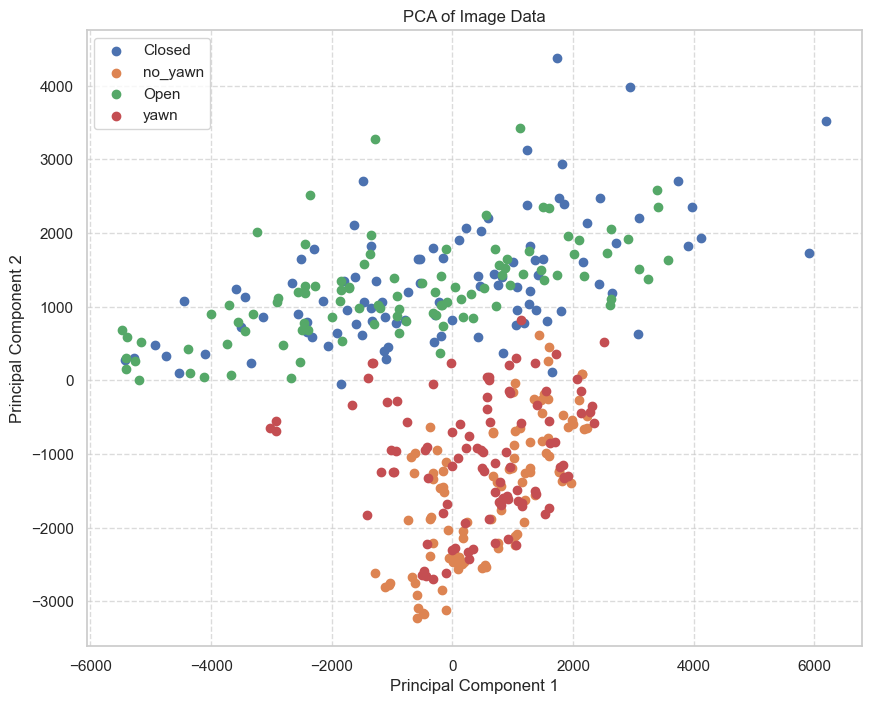

In [84]:
def apply_pca_on_images(dataset_dir, class_labels, n_samples=100):
    all_images = []
    all_labels = []
    
    for label in class_labels:
        class_path = os.path.join(dataset_dir, label)
        images = random.sample(os.listdir(class_path), n_samples)
        
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, (64, 64)).flatten()  # Resize to reduce dimensionality
            all_images.append(img_resized)
            all_labels.append(label)
    
    all_images = np.array(all_images)
    
    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(all_images)
    
    # Plot the PCA result
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(class_labels):
        plt.scatter(pca_result[np.array(all_labels) == label, 0], 
                    pca_result[np.array(all_labels) == label, 1], 
                    label=label)
    
    plt.title("PCA of Image Data")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

apply_pca_on_images(dataset_dir, class_labels)


The PCA (Principal Component Analysis) plot provides a clear visualization of how image data from four different classes—"Closed," "no_yawn," "Open," and "yawn"—distributes along the first two principal components. Each class is represented by a distinct color, which makes it easier to observe the separation and overlap between them. The "Closed" and "Open" classes are particularly well-separated, with their data points clustered distinctly along the axes, indicating that the features extracted from the images are quite effective in distinguishing these classes. On the other hand, the "no_yawn" and "yawn" classes, while still distinguishable, show some overlap. This suggests that these two classes share common features, which might make them more challenging to differentiate based on the first two principal components alone.

Principal Component 1 appears to be particularly important in distinguishing between the "Closed" and "Open" classes, as these are spread out along this axis. This indicates that the component captures features that are crucial for separating these two states. Principal Component 2, meanwhile, plays a key role in differentiating the "no_yawn" and "yawn" classes, especially where the "yawn" class clusters lower on the plot. The distinct clusters formed for each class suggest that the PCA has effectively captured the variance in the data, leading to a meaningful reduction in dimensionality that still preserves the key differences between classes.

However, the plot also highlights some potential challenges. The overlap between the "no_yawn" and "yawn" classes suggests that distinguishing between these two states might require more than just the first two principal components. This overlap could be due to similarities in the image features that define these states, indicating a potential need for more sophisticated feature extraction or preprocessing techniques. Additionally, the spread of points within certain clusters, such as the "Open" class, suggests variability within these classes, possibly due to differences in image conditions like lighting, angle, or resolution.

## Visualize yawn image(Background is unnecessary. We need only face image array) 


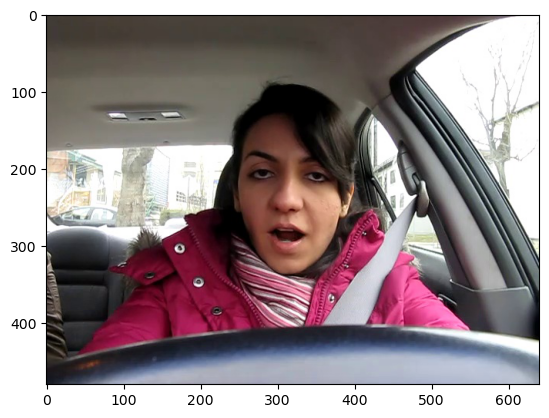

In [10]:
plt.imshow(plt.imread(r"Dataset\train\yawn\10.jpg"))

# Ingest Data 

In [87]:
def face_for_yawn(direc=r"Dataset", face_cas_path=r"Cascade/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                roi_color = image_array[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no

def get_data(dir_path=r"Dataset", face_cas=r"Cascade/haarcascade_frontalface_default.xml", eye_cas=r"Cascade/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num += 2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    
    # Check and ensure consistency in shape
    for entry in yaw_no + data:
        if entry[0].shape != (145, 145, 3):
            raise ValueError(f"Inconsistent shape found: {entry[0].shape}")
    
    yaw_no.extend(data)
    return np.array(yaw_no, dtype=object)

# Example usage
try:
    new_data = append_data()
except ValueError as e:
    print(e)


0
1
2
3


In [88]:
# Seperate Data into Features and Labels
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

# Reshape
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

# LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

# Split into Train and Test
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Data Augmentation

In [89]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model Building

## Model 1

In [40]:
model1 = Sequential()

model1.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model1.add(MaxPooling2D(2, 2))

model1.add(Conv2D(128, (3, 3), activation="relu"))
model1.add(MaxPooling2D(2, 2))

model1.add(Conv2D(64, (3, 3), activation="relu"))
model1.add(MaxPooling2D(2, 2))

model1.add(Conv2D(32, (3, 3), activation="relu"))
model1.add(MaxPooling2D(2, 2))

model1.add(Flatten())
model1.add(Dropout(0.5))

model1.add(Dense(64, activation="relu"))
model1.add(Dense(4, activation="softmax"))

model1.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [41]:
history1 = model1.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 316s 7s/step - loss: 1.3498 - accuracy: 0.4046 - val_loss: 1.2385 - val_accuracy: 0.6419
Epoch 2/50
43/43 [==============================] - 297s 7s/step - loss: 0.8458 - accuracy: 0.6622 - val_loss: 0.4962 - val_accuracy: 0.7889
Epoch 3/50
43/43 [==============================] - 284s 7s/step - loss: 0.4853 - accuracy: 0.8018 - val_loss: 0.3903 - val_accuracy: 0.8443
Epoch 4/50
43/43 [==============================] - 289s 7s/step - loss: 0.3969 - accuracy: 0.8404 - val_loss: 0.3000 - val_accuracy: 0.8841
Epoch 5/50
43/43 [==============================] - 287s 7s/step - loss: 0.3442 - accuracy: 0.8612 - val_loss: 0.2747 - val_accuracy: 0.8893
Epoch 6/50
43/43 [==============================] - 279s 6s/step - loss: 0.3313 - accuracy: 0.8664 - val_loss: 0.2738 - val_accuracy: 0.8910
Epoch 7/50
43/43 [==============================] - 293s 7s/step - loss: 0.2949 - accuracy: 0.8834 - val_loss: 0.2376 - val_accuracy: 0.9152
Epoch 8/50
43

## Model 2

In [91]:
# Define the image size that ViT expects
image_size = 224  # ViT models typically use 224x224 images
batch_size = 32

# Load the feature extractor from transformers
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Load the dataset
data_dir = 'Dataset'
train_ds = image_dataset_from_directory(
    dataset_dir,
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=(image_size, image_size),
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds = image_dataset_from_directory(
    dataset_dir,
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=(image_size, image_size),
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=42
)

# Normalize the images using the ViT feature extractor's mean and std
def preprocess_images(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Scale images to [0, 1]
    image = tf.image.resize(image, (image_size, image_size))
    image = (image - feature_extractor.image_mean) / feature_extractor.image_std
    return image, label

train_ds = train_ds.map(preprocess_images)
val_ds = val_ds.map(preprocess_images)



C:\Users\rohan\anaconda3\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning:

The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.



Found 2900 files belonging to 4 classes.
Using 2320 files for training.
Found 2900 files belonging to 4 classes.
Using 580 files for validation.


In [93]:
# Number of classes based on your folders (Closed, no_yawn, Open, yawn)
num_classes = 4

# Load the pre-trained ViT model
base_model = TFViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=num_classes)
base_model.trainable=False
inputs = tf.keras.Input(shape=(224, 224, 3))
transposed_inputs = tf.transpose(inputs, perm=[0, 3, 1, 2])
vit_outputs = base_model.vit(transposed_inputs)[0]

# Add custom layers on top of ViT
x = GlobalAveragePooling1D()(vit_outputs)  # Global average pooling
x = Dropout(0.2)(x)  # Add dropout for regularization
x = Dense(512, activation='relu')(x)  # Add a fully-connected layer
x = Dropout(0.2)(x)  # Add another dropout layer
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer for classification

# Build the model
model2 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_vit_model_with_custom_layers.h5', monitor='val_loss', save_best_only=True)
]

# Train the model
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # Adjust the number of epochs based on your dataset and hardware
    callbacks=callbacks
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
73/73 [==============================] - ETA: 0s - loss: 0.9058 - accuracy: 0.7866 

C:\Users\rohan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



73/73 [==============================] - 2116s 29s/step - loss: 0.9058 - accuracy: 0.7866 - val_loss: 0.6103 - val_accuracy: 0.9500
Epoch 2/10
73/73 [==============================] - 1593s 22s/step - loss: 0.4983 - accuracy: 0.9453 - val_loss: 0.3755 - val_accuracy: 0.9569
Epoch 3/10
73/73 [==============================] - 1053s 14s/step - loss: 0.3287 - accuracy: 0.9569 - val_loss: 0.2633 - val_accuracy: 0.9603
Epoch 4/10
73/73 [==============================] - 1021s 14s/step - loss: 0.2398 - accuracy: 0.9672 - val_loss: 0.2020 - val_accuracy: 0.9672
Epoch 5/10
73/73 [==============================] - 1020s 14s/step - loss: 0.1903 - accuracy: 0.9703 - val_loss: 0.1643 - val_accuracy: 0.9690
Epoch 6/10
73/73 [==============================] - 1049s 14s/step - loss: 0.1541 - accuracy: 0.9776 - val_loss: 0.1389 - val_accuracy: 0.9810
Epoch 7/10
73/73 [==============================] - 1063s 15s/step - loss: 0.1313 - accuracy: 0.9767 - val_loss: 0.1215 - val_accuracy: 0.9810
Epoch 8/10

## Training Summary

C:\Users\rohan\AppData\Local\Temp\ipykernel_7576\1223887841.py:39: UserWarning:

The figure layout has changed to tight



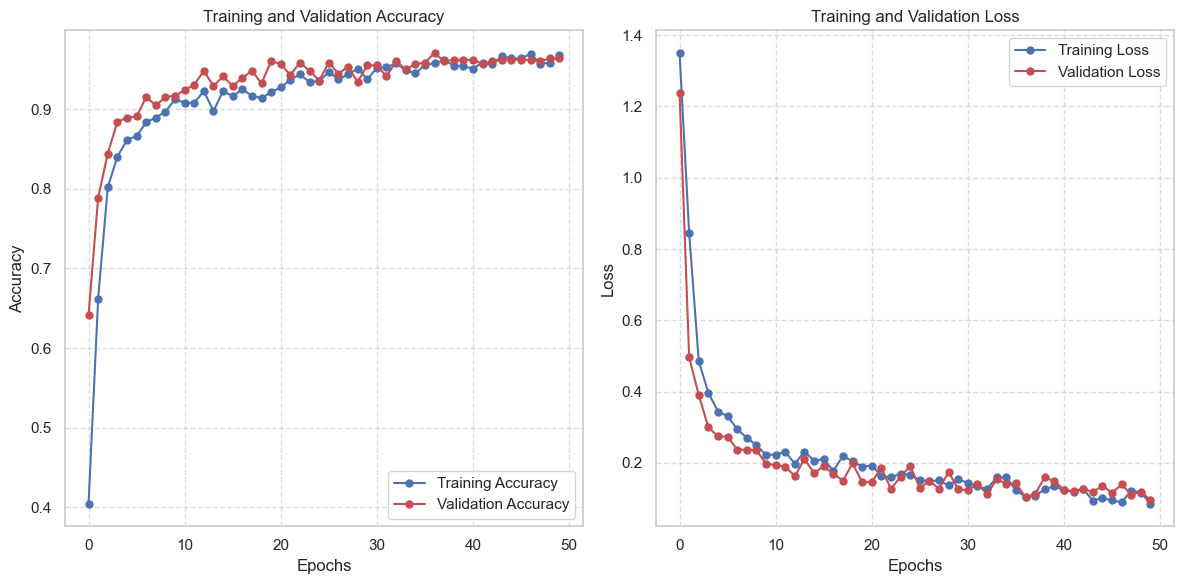

In [101]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss curves.

    Parameters:
    history : History object
        The history object returned by the `fit` method of a Keras model. 
        It contains the training and validation accuracy and loss over the epochs.
    """
    # Extracting history data
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))

    # Plotting Accuracy
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'b-o', label='Training Accuracy', markersize=5)
    plt.plot(epochs, val_accuracy, 'r-o', label='Validation Accuracy', markersize=5)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-o', label='Training Loss', markersize=5)
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss', markersize=5)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show plots
    plt.show()
# For Model 1
plot_training_history(history1)

C:\Users\rohan\AppData\Local\Temp\ipykernel_7576\1223887841.py:39: UserWarning:

The figure layout has changed to tight



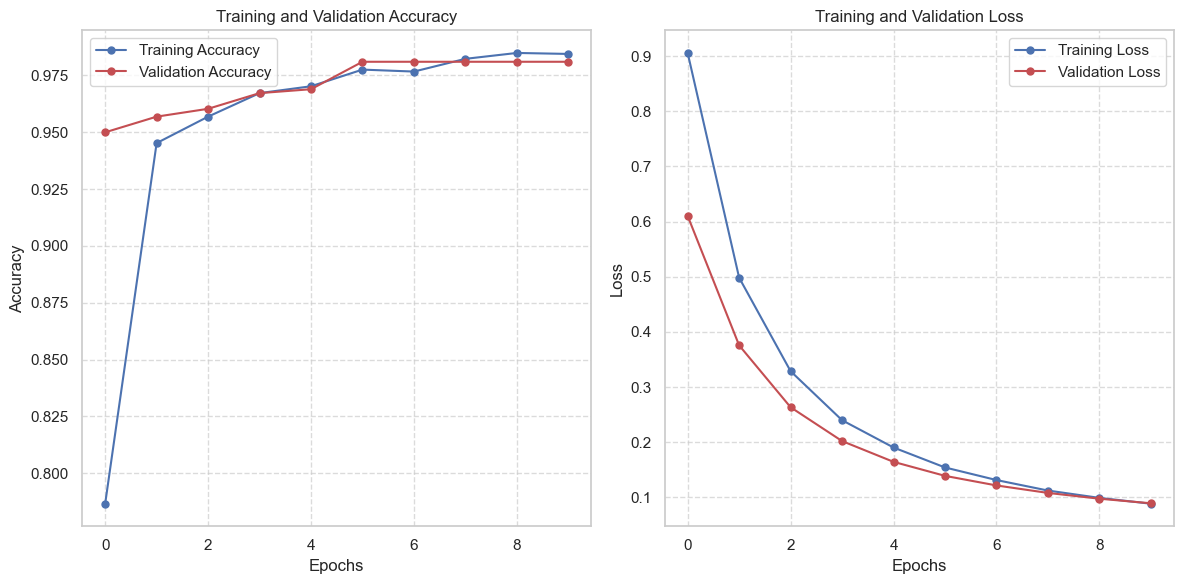

In [102]:
# For Model 2
plot_training_history(history2)

## History

# Model Evaluation

In [59]:
def extract_labels_and_predictions(generator, model):
    y_true = []
    y_pred_prob = []
    
    # Get the number of steps to iterate through the generator
    steps = len(generator)  # `len(generator)` provides the number of batches

    for _ in range(steps):
        x_batch, y_batch = generator.next()
        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred_prob.extend(model.predict(x_batch))
    
    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class predictions
    
    return y_true, y_pred, y_pred_prob

# Use the extract function with your test generator and model
y_true1, y_pred1, y_pred_prob1 = extract_labels_and_predictions(test_generator, model1)

# Calculate F1 Score, Precision, and Recall
f11 = f1_score(y_true1, y_pred1, average='weighted')
precision1 = precision_score(y_true1, y_pred1, average='weighted')
recall1 = recall_score(y_true,1 y_pred1, average='weighted')

print(f'F1 Score: {f11:.4f}')
print(f'Precision: {precision1:.4f}')
print(f'Recall: {recall1:.4f}')




1/1 [==============================] - 2s 2s/step
F1 Score: 0.9635
Precision: 0.9636
Recall: 0.9637


In [104]:
# For Model 2
def extract_labels_and_predictions(dataset, model):
    y_true = []
    y_pred_prob = []
    
    # Iterate through the dataset
    for images, labels in dataset:
        y_true.extend(labels.numpy())  # True labels
        y_pred_prob.extend(model.predict(images))  # Predicted probabilities
    
    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class predictions
    
    return y_true, y_pred, y_pred_prob

# Use the extract function with your validation dataset and model
y_true2, y_pred2, y_pred_prob2 = extract_labels_and_predictions(val_ds, model2)

# Calculate F1 Score, Precision, and Recall
f12 = f1_score(y_true2, y_pred2, average='weighted')
precision2 = precision_score(y_true2, y_pred2, average='weighted')
recall2 = recall_score(y_true2, y_pred2, average='weighted')

# Print the metrics
print(f'F1 Score: {f12:.4f}')
print(f'Precision: {precision2:.4f}')
print(f'Recall: {recall2:.4f}')

1/1 [==============================] - 5s 5s/step
F1 Score: 0.9810
Precision: 0.9818
Recall: 0.9810


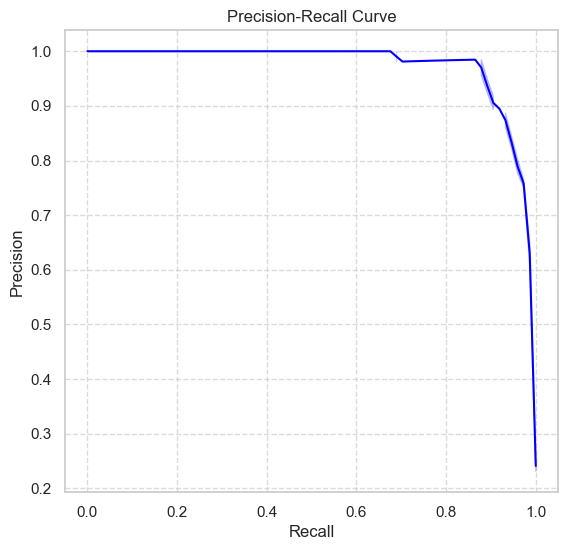

In [69]:
# PLot Precision Recall Curve
# Assuming binary classification with two classes
# Binarize the true labels for the positive class
y_true_binary`=label_binarize(y_true`,classes=[0,1])[:,1]
y_pred_prob_pos`=y_pred_prob`[:,1]  

# Calculate Precision-Recall values
precision1,recall1,_=precision_recall_curve(y_true_binary`,y_pred_prob_pos`)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x=recall1,y=precision1,color='blue')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True, linestyle='--',alpha=0.7)




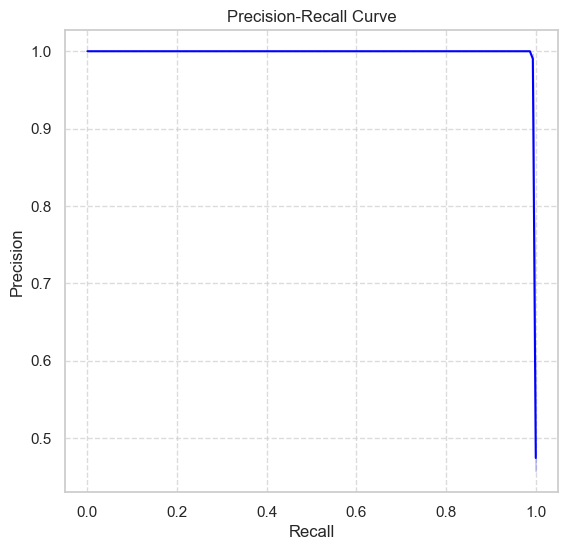

In [106]:
# PLot Precision Recall Curve
# Assuming binary classification with two classes
# Binarize the true labels for the positive class
y_true_binary2=label_binarize(y_true2,classes=[0,1])[:,1]
y_pred_prob_pos2=y_pred_prob2[:,1]  

# Calculate Precision-Recall values
precisio2,recal2,_=precision_recall_curve(y_true_binary2,y_pred_prob_pos2)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x=recal2,y=precisio2,color='blue')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True, linestyle='--',alpha=0.7)

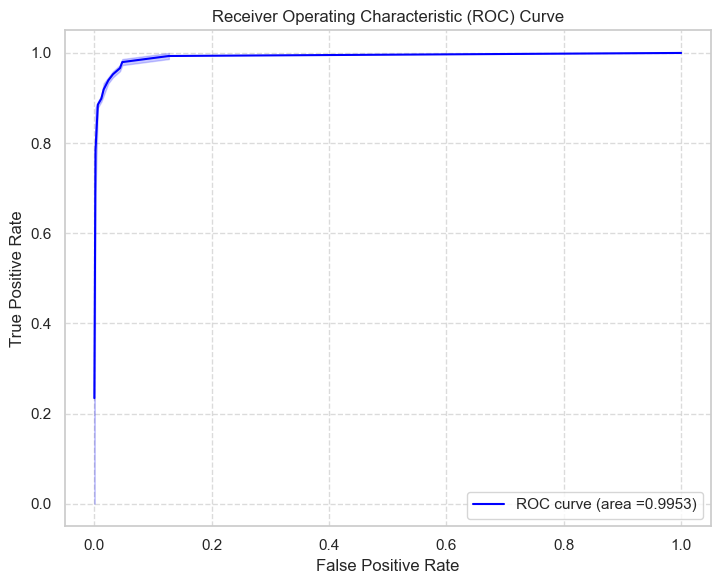

In [68]:
# Calculate ROC curve values
fpr1,tpr1, _ =roc_curve(y_true_binary1,y_pred_prob_pos1)
roc_auc1 =roc_auc_score(y_true_binary1,y_pred_prob_pos1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x=fpr1,y=tpr1,color='blue',label=f'ROC curve (area ={roc_auc1:.4f})')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True,linestyle='--',alpha=0.7)

plt.tight_layout()
plt.show()


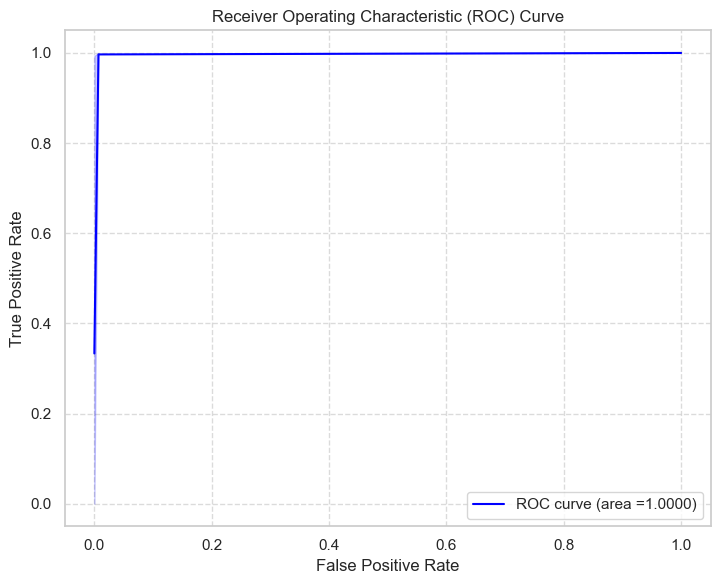

In [107]:
# Calculate ROC curve values
fpr2,tpr2, _ =roc_curve(y_true_binary2,y_pred_prob_pos2)
roc_auc2 =roc_auc_score(y_true_binary2,y_pred_prob_pos2)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x=fpr2,y=tpr2,color='blue',label=f'ROC curve (area ={roc_auc2:.4f})')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True,linestyle='--',alpha=0.7)

plt.tight_layout()
plt.show()

## Save Model

In [54]:
model1.save("savedmodels/drowiness_new7.h5")

C:\Users\rohan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [55]:
model1.save("savedmodels/drowiness_new7.model")

INFO:tensorflow:Assets written to: drowiness_new7.model\assets


INFO:tensorflow:Assets written to: drowiness_new7.model\assets


In [108]:
model2.save('savedmodels/drowsiness_new.model')
model2.save('savedmodels/drowsiness_new.h5')

INFO:tensorflow:Assets written to: drowsiness_new.model\assets


INFO:tensorflow:Assets written to: drowsiness_new.model\assets
C:\Users\rohan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

